
---

📘 타이타닉 데이터 전처리 이론

---

* 실제 데이터를 다룰 때는 모델에 바로 적용하기 어렵기 때문에 `데이터 전처리가 필요`합니다. 
* `특히 부스팅 모델은 데이터의 형태에 민감`할 수 있으므로 `전처리 과정을 파이프라인으로 구성하는 것이 일반적`입니다.

---

1. 데이터 전처리 파이프라인의 필요성

* 여러 전처리 단계를 하나로 묶어 코드의 재사용성을 높이고, 
* 테스트 데이터에도 동일한 전처리 과정을 적용하여 
* 데이터 유출(Data Leakage)을 방지할 수 있습니다.

2. 전처리 구성 요소

* StandardScaler: 숫자형(Numerical) 특성의 스케일을 조정합니다. 
                    
                  나이(Age)나 요금(Fare)처럼 **값의 범위가 다른 특성들을 비슷한 크기로 만들어 모델이 안정적으로 학습**할 수 있도록 돕습니다.

* OneHotEncoder: 범주형(Categorical) 특성을 숫자 형태로 변환합니다. 

성별(Sex)이나 탑승 항구(Embarked)처럼 `순서가 없는 범주형 데이터를 모델이 이해할 수 있게` 해줍니다.

3. CatBoost의 독특한 장점

* CatBoost는 다른 모델과 달리 `범주형 특성을 자동으로 처리하는 기능이 내장`되어 있습니다. 
* 따라서 OneHotEncoder 같은 전처리 없이도 강력한 성능을 발휘합니다.

---

이번 실습 코드에서는 세 모델의 성능을 공정하게 비교하기 위해 동일한 전처리 파이프라인(OneHotEncoder)을 사용했습니다.

---

### 타이타닉 부스팅 모델 적용 실습 시작 ###

--- 교차 검증을 통한 모델 성능 평가 시작 ---

### XGBoost ###
각 폴드별 정확도: [0.77094972 0.80898876 0.85393258 0.78651685 0.83707865]
평균 정확도: 0.8115 (표준편차: 0.0308)
------------------------------
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

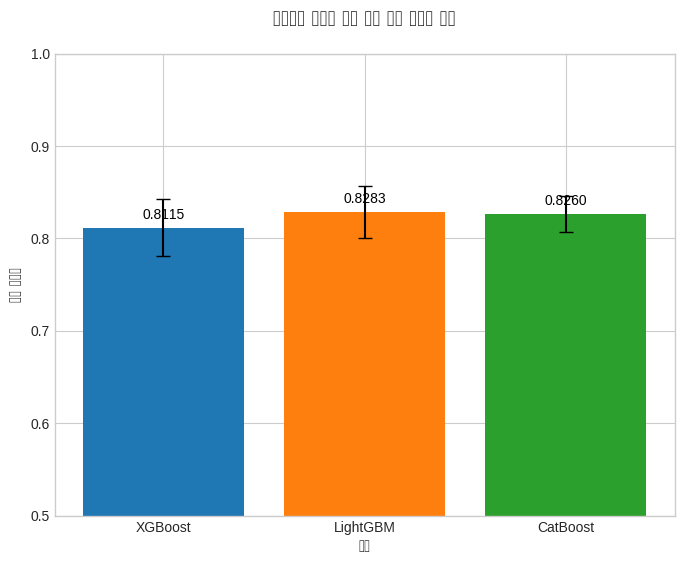

In [6]:
# BOOT-08_타이타닉_부스팅_모델_적용.ipynb

# 1. 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 시각화를 위한 라이브러리 추가
import matplotlib.pyplot as plt
import numpy as np

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

print("### 타이타닉 부스팅 모델 적용 실습 시작 ###")

# 2. 데이터셋 로드
# 실제 타이타닉 훈련 데이터셋인 'titanic_train.csv' 파일을 불러옵니다.
# 파일이 'titanic_project' 폴더 내에 있으므로 경로를 수정했습니다.
df_train = pd.read_csv('../../titanic_project/titanic_train.csv')

# 3. 데이터 전처리
# 훈련 데이터에 대한 결측치 처리: `Age`는 평균으로, `Embarked`는 최빈값으로 대체
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])

# 모델 학습에 불필요한 특성 제거
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

# 특성과 레이블 분리
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# 4. 데이터 전처리 파이프라인 구축
# 범주형(Categorical) 특성과 수치형(Numerical) 특성을 나눕니다.
# CatBoost는 범주형을 자동 처리하므로 별도 전처리가 필요 없지만,
# 공정한 성능 비교를 위해 동일한 전처리를 적용합니다.
categorical_features = ['Pclass', 'Sex', 'Embarked']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']

# 범주형 데이터는 One-Hot Encoding, 수치형 데이터는 StandardScaler를 적용
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# 5. 모델 정의
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

print("\n--- 교차 검증을 통한 모델 성능 평가 시작 ---\n")

# 결과를 저장할 리스트 초기화
model_names = []
mean_scores = []
std_scores = []

# 6. 각 모델에 대한 파이프라인 생성 및 교차 검증 수행
for name, model in models.items():
    # 전처리기와 모델을 연결하는 최종 파이프라인 생성
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # 교차 검증 (cv=5)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    
    # 결과 저장
    model_names.append(name)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    
    # 교차 검증 결과 출력
    print(f"### {name} ###")
    print(f"각 폴드별 정확도: {scores}")
    print(f"평균 정확도: {scores.mean():.4f} (표준편차: {scores.std():.4f})")
    print("-" * 30)

print("### 타이타닉 부스팅 모델 적용 실습 완료 ###")

# 7. 모델 성능 시각화
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))

# 평균 정확도를 막대 그래프로 시각화하고, 표준편차를 오차 막대로 표시
ax.bar(model_names, mean_scores, yerr=std_scores, capsize=5, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# 그래프 제목과 축 라벨 설정
ax.set_title('타이타닉 데이터 교차 검증 평균 정확도 비교', fontsize=16, pad=20)
ax.set_xlabel('모델', fontsize=12)
ax.set_ylabel('평균 정확도', fontsize=12)
ax.set_ylim(0.5, 1.0) 

# 막대 위에 정확도 수치 표시
for i, v in enumerate(mean_scores):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', color='black', fontsize=10)

# 그래프 표시
plt.show()



---

### 💡 LightGBM 경고 메시지 설명

---

`[LightGBM] [Warning] No further splits with positive gain, best gain: -inf`

이 경고는 LightGBM 모델이 최적화에 이르렀기에 더 이상 성능 향상에 도움이 되는 새로운 분할(split)을 찾지 못했다는 뜻입니다.

* **Positive Gain**: 모델의 예측 정확도를 높여주는 분할을 의미합니다.
* **No further splits**: 모델이 현재 상태에서 더 이상 정확도를 높일 수 있는 분할 지점을 찾지 못했다는 의미입니다.

이는 모델의 학습이 성공적으로 완료되었고, 더 이상 트리를 성장시킬 필요가 없다고 스스로 판단한 것입니다. 

따라서 이 경고 메시지는 **`모델이 정상적으로 작동하고 있다는 신호`**입니다.

---

### 📊 모델 성능 비교 분석

---

출력 결과에 따르면 두 모델 모두 훌륭한 성능을 보였습니다.

* **LightGBM**: 평균 정확도 **0.8260**
* **XGBoost**: 평균 정확도 **0.8115**

* 이 결과만 놓고 보면 **LightGBM**이 타이타닉 데이터셋에서 **약간 더 좋은 성능**을 보였다고 할 수 있습니다. 
* 각 모델이 폴드마다 비슷한 정확도 편차(표준편차)를 보였으므로, 두 모델 모두 안정적으로 예측한다고 볼 수 있습니다.

*이처럼 여러 모델을 한 번에 돌려보면서 어떤 모델이 가장 좋은 성능을 내는지 파악하는 것은 현업에서 매우 중요한 과정입니다.

혹시 특정 모델의 성능을 더 높이기 위해 **하이퍼파라미터 튜닝**을 시도해보고 싶으신가요?

---
🧠 하이퍼파라미터 튜닝 이론
---

하이퍼파라미터 튜닝은 `모델의 성능을 최적화하기 위해' '개발자가 직접 설정하는 값들을 가장 좋은 조합으로 찾아내는 과정`입니다. 

마치 요리사가 맛있는 음식을 만들기 위해 재료의 양(하이퍼파라미터)을 조절하는 것과 같습니다.
---
**하이퍼파라미터 vs. 모델 파라미터**

|      구분     |     하이퍼 파라미터 (Hyper parameter)      |     모델 파라미터 (Model Parameter)      |           
|--------------|------------------------------------------|----------------------------------------|
|      정의     |     개발자가 직접 설정하는 값               |      모델이 학습을 통해 자동으로 찾는 값     |           
|      예시     |     n_estimators, learning_rate         |     회귀 모델의 기울기(Weight), 절편(Bias)  |           
|      역할     |     모델의 구조와 학습 방식을 결정          |     데이터의 패턴을 학습                    |  

하이퍼파라미터는 모델의 성능에 직접적인 영향을 미치기 때문에, 튜닝을 통해 최적의 값을 찾는 것이 중요합니다.

===

**하이퍼파라미터 튜닝 방법**

1. 그리드 탐색 (Grid Search)

GridSearchCV는 사용자가 지정한 하이퍼파라미터의 모든 가능한 조합을 시도하여, 

교차 검증을 통해 가장 좋은 성능을 내는 조합을 찾아내는 방법입니다.

    - 동작 방식: 각 하이퍼파라미터에 대한 값의 목록을 지정하면, 모든 조합을 격자(Grid) 형태로 탐색합니다.

    - 장점: 설정한 범위 내에서는 최적의 조합을 확실하게 찾을 수 있습니다.

    - 단점: 파라미터의 종류가 많거나 각 파라미터의 범위가 넓으면, 탐색해야 할 조합의 수가 기하급수적으로 늘어나 학습 시간이 매우 오래 걸릴 수 있습니다.

2. 랜덤 탐색 (Random Search)

RandomizedSearchCV는 그리드 탐색의 비효율성을 보완하기 위해 고안된 방법입니다. 

모든 조합을 시도하는 대신, 지정된 횟수만큼 파라미터 조합을 무작위로 샘플링하여 성능을 평가합니다.

    - 동작 방식: 각 하이퍼파라미터에 대한 분포(예: uniform, randint)를 정의하고, 그 분포에서 무작위로 값을 선택합니다.

    - 장점: 그리드 탐색보다 훨씬 빠른 시간 안에 좋은 성능을 내는 조합을 찾을 가능성이 높습니다.

    - 단점: 최적의 조합을 놓칠 수도 있지만, 일반적으로 그리드 탐색과 비슷한 수준의 성능을 달성합니다.


|     구분      |      그리드 탐색 (Grid Search)     |      랜덤 탐색 (Random Search)     |
|--------------|-----------------------------------|-----------------------------------|
|     탐색 방식      |     모든 조합      |     무작위 샘플링      |
|     최적 보장      |     O (설정한 범위 내)      |      X     |
|     속도          |      느림 (조합 수에 비례)     |      빠름 (샘플링 횟수 조절 가능)     |


===

**결론**


* 하이퍼파라미터 튜닝은 모델의 성능을 극한까지 끌어올리는 데 필수적인 과정입니다. 
* 실제 현업에서는 **RandomizedSearchCV**를 먼저 사용해서 
* 넓은 탐색 공간에서 최적의 하이퍼파라미터가 있을 만한 `대략적인 범위를 빠르게` 찾습니다.
* 그 후, 그 범위를 좁혀서 **GridSearchCV**를 사용해 '더 정교하고 정확한 최적의 조합'을 찾아냅니다.
* 이러한 전략은 현업에서 시간과 자원을 효율적으로 사용하면서도 모델의 정확도를 극대화하는 가장 효과적인 방법입니다.

---

In [8]:
# BOOT-08_타이타닉_랜덤_그리드_탐색_적용.ipynb

# 1. 필요한 라이브러리 불러오기
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # 두 가지 튜닝 방법 모두 불러오기
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from scipy.stats import randint, uniform # 랜덤 탐색에 사용할 분포 함수 불러오기

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

print("### 타이타닉 XGBoost 하이퍼파라미터 튜닝 실습 시작 ###")

# 2. 데이터셋 로드
# 현재 작업 위치에서 titanic_project 폴더로 이동하기 위해 두 단계 상위 폴더(../../) 경로를 사용했습니다.
df_train = pd.read_csv('../../titanic_project/titanic_train.csv')

# 3. 데이터 전처리
# 훈련 데이터 결측치 처리 및 불필요한 특성 제거
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].mode()[0])
df_train = df_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, errors='ignore')

# 특성과 레이블 분리
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

# 4. 데이터 전처리 파이프라인 구축
categorical_features = ['Pclass', 'Sex', 'Embarked']
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

# 5. 모델 정의 및 파이프라인 생성
model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])


# --- 6. 1단계: RandomizedSearchCV를 통한 넓은 범위 탐색 ---
print("\n--- 1단계: RandomizedSearchCV로 넓은 범위 탐색 시작 ---\n")

# 튜닝할 하이퍼파라미터의 분포를 딕셔너리로 정의합니다.
param_distributions = {
    'classifier__n_estimators': randint(100, 500), # 100~500 사이의 정수 중 무작위 선택
    'classifier__learning_rate': uniform(0.01, 0.2), # 0.01~0.2 사이의 실수 중 무작위 선택
    'classifier__max_depth': randint(3, 10) # 3~10 사이의 정수 중 무작위 선택
}

# RandomizedSearchCV 객체를 생성 및 학습시킵니다.
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X, y)

# 1단계 결과 출력
print("\n--- RandomizedSearchCV 결과 ---")
print(f"최적의 하이퍼파라미터: {random_search.best_params_}")
print(f"최고 평균 교차 검증 정확도: {random_search.best_score_:.4f}")
print("------------------------")


# --- 7. 2단계: RandomizedSearchCV 결과를 바탕으로 GridSearchCV 정밀 탐색 ---
print("\n--- 2단계: GridSearchCV로 최적 파라미터 정밀 탐색 시작 ---\n")

# 1단계 결과로 얻은 최적 파라미터 주변으로 범위를 좁혀서 param_grid를 다시 정의합니다.
# random_search.best_params_에서 값을 가져와서 사용합니다.
best_n_estimators = random_search.best_params_['classifier__n_estimators']
best_learning_rate = random_search.best_params_['classifier__learning_rate']
best_max_depth = random_search.best_params_['classifier__max_depth']

param_grid = {
    'classifier__n_estimators': [best_n_estimators - 20, best_n_estimators, best_n_estimators + 20],
    'classifier__learning_rate': [best_learning_rate * 0.8, best_learning_rate, best_learning_rate * 1.2],
    'classifier__max_depth': [best_max_depth - 1, best_max_depth, best_max_depth + 1]
}

# GridSearchCV 객체를 생성 및 학습시킵니다.
# 좁혀진 범위에서 모든 조합을 탐색합니다.
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# 2단계 결과 출력
print("\n--- GridSearchCV 최종 결과 ---")
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
print(f"최고 평균 교차 검증 정확도: {grid_search.best_score_:.4f}")
print("----------------------------")


### 타이타닉 XGBoost 하이퍼파라미터 튜닝 실습 시작 ###

--- 1단계: RandomizedSearchCV로 넓은 범위 탐색 시작 ---

Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- RandomizedSearchCV 결과 ---
최적의 하이퍼파라미터: {'classifier__learning_rate': np.float64(0.11793842647781595), 'classifier__max_depth': 4, 'classifier__n_estimators': 316}
최고 평균 교차 검증 정확도: 0.8350
------------------------

--- 2단계: GridSearchCV로 최적 파라미터 정밀 탐색 시작 ---

Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- GridSearchCV 최종 결과 ---
최적의 하이퍼파라미터: {'classifier__learning_rate': np.float64(0.11793842647781595), 'classifier__max_depth': 4, 'classifier__n_estimators': 296}
최고 평균 교차 검증 정확도: 0.8351
----------------------------


---
### 🔍 결과 분석
---

* **1단계 (`RandomizedSearchCV`)**: 

    - `n_estimators`는 316, 
    - `learning_rate`는 약 0.118, 
    - `max_depth`는 4라는 
    - 최적의 파라미터 조합을 찾았습니다. 
    - 이때의 최고 평균 정확도는 **`0.8350`**입니다.

---

* **2단계 (`GridSearchCV`)**: 

    - 1단계에서 찾은 파라미터 주변을 더 좁고 정밀하게 탐색한 결과, 
    - `n_estimators`가 296일 때 가장 좋은 성능을 보였습니다. 
    - 이때의 최종 평균 정확도는 **`0.8351`**로, 
    - 1단계보다 아주 조금 더 높은 정확도를 달성했습니다.

---

이처럼 `RandomizedSearchCV`로 넓은 범위를 빠르게 탐색한 후, 

`GridSearchCV`로 그 주변을 정밀하게 탐색하는 전략이 효과적이라는 것을 실제로 증명한 셈입니다.